## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras 
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split 
from keras.applications.vgg16 import VGG16 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pydicom 
from itertools import chain 
from pydicom import dcmread 
from skimage.io import imread 
from tqdm import tqdm 
import seaborn as sns 
from scipy.stats import mode 
import sklearn.metrics as metrics
from random import sample 
from sklearn.model_selection import train_test_split 
import tensorflow as tf 
from keras import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint
from sklearn.metrics import precision_score ,recall_score ,f1_score,accuracy_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
20471,00005476_002.png,Emphysema,2,5476,58,F,PA,2500,2048,0.171,0.171,NaN,/data/images_003/images/00005476_002.png
50105,00012681_005.png,No Finding,5,12681,58,F,AP,2048,2500,0.168,0.168,NaN,/data/images_006/images/00012681_005.png
111437,00030477_000.png,Infiltration,0,30477,78,F,PA,2544,3056,0.139,0.139,NaN,/data/images_012/images/00030477_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df["pneumonia_class"]=np.where(all_xray_df["Pneumonia"]==1,1,0)

## Create your training and testing data:

def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    len_pos= int(len(d[d.pneumonia_class==1]))
    len_test=int((len_pos*0.5*100)/20)

    train_1=np.random.choice(d[d.pneumonia_class==1]["Image Index"],size=int(len_pos/2),replace=False)
    train_0=np.random.choice(d[d.pneumonia_class==0]["Image Index"],size=int(len_pos/2),replace=False)
    train_data=np.append(train_1,train_0)
    #remove the images that were used in training data set 
    d_1=d.loc[np.isin(d["Image Index"],train_data,invert=True)]
    test_1=np.random.choice(d_1[d_1.pneumonia_class==1]["Image Index"],size=int(len_pos/2),replace=False)
    test_0=np.random.choice(d_1[d_1.pneumonia_class==0]["Image Index"],size=int(len_test*0.8),replace=False)

    val_data=np.append(test_1,test_0)
    
    return train_data, val_data
    
 This was one way I split the data but seems to mess thing up so will return to sklearn method,  I can't tell what I did wrong in my method tho, I do check that data does not overlap and that imabalance is not present , maybe it causes data leakage somewhere

In [5]:
def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['pneumonia_class'])

    p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
    np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    p_inds = valid_df[valid_df.pneumonia_class==1].index.tolist()
    np_inds = valid_df[valid_df.pneumonia_class==0].index.tolist()
    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    
    return train_df, valid_df

In [6]:
# use the splitted and sampled image indexes to create our test and train datasets
# make sure dataset is split in a balanced manner 
train,test=create_splits(all_xray_df)
print(test["pneumonia_class"].value_counts()/len(test))
print(train["pneumonia_class"].value_counts()/len(train))

0    0.8
1    0.2
Name: pneumonia_class, dtype: float64
1    0.5
0    0.5
Name: pneumonia_class, dtype: float64


In [7]:
train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
62140,00015376_021.png,Effusion|Pneumonia,21,15376,60,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
101021,00026825_008.png,Pneumonia,8,26825,35,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
13547,00003523_013.png,Infiltration|Pneumonia,13,3523,23,F,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
30667,00008008_046.png,Effusion|Pneumonia,46,8008,23,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
70983,00017504_061.png,Edema|Infiltration|Pneumonia,61,17504,12,F,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22341,00005924_000.png,No Finding,0,5924,50,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
19590,00005203_000.png,Hernia,0,5203,55,F,PA,2582,2565,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
110022,00029943_003.png,Atelectasis|Mass|Pneumothorax,3,29943,64,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
15592,00004085_009.png,No Finding,9,4085,46,F,PA,2894,2685,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [8]:
# it is necessary for data generator that labels are strings 
train.pneumonia_class=train.pneumonia_class.astype(str)
test.pneumonia_class=test.pneumonia_class.astype(str)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(myitem):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    # Image pre-processing:
    # Remove potential noise from our images (Otsu method)
    # Enforce some normalization across images
    # Enlarge your dataset
    # Resize for CNN arcitectures' required input.
    if (myitem== 'train'):
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.01, 
                                  width_shift_range=0.01, 
                                  rotation_range=20, 
                                  shear_range = 0.05,
                                  zoom_range=0.01)
    else:
        
    
        my_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    
    
    return my_idg

def make_train_gen(my_train_idg,train_df,batch_size,img_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                          x_col ="path" ,
                                          y_col ="pneumonia_class" ,
                                          class_mode = 'binary',
                                          target_size = (img_size,img_size), 
                                          batch_size = batch_size
                                          )
     # Todo

    return train_gen


def make_val_gen(my_val_idg,val_data,batch_size,img_size):
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None,
                                             x_col = "path" 
                                             ,y_col = "pneumonia_class",
                                             class_mode = 'binary',
                                             target_size = (img_size,img_size) ,
                                             batch_size = batch_size ) 
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_val_idg=my_image_augmentation("val")
val_gen=make_val_gen(my_val_idg,test,200,224)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


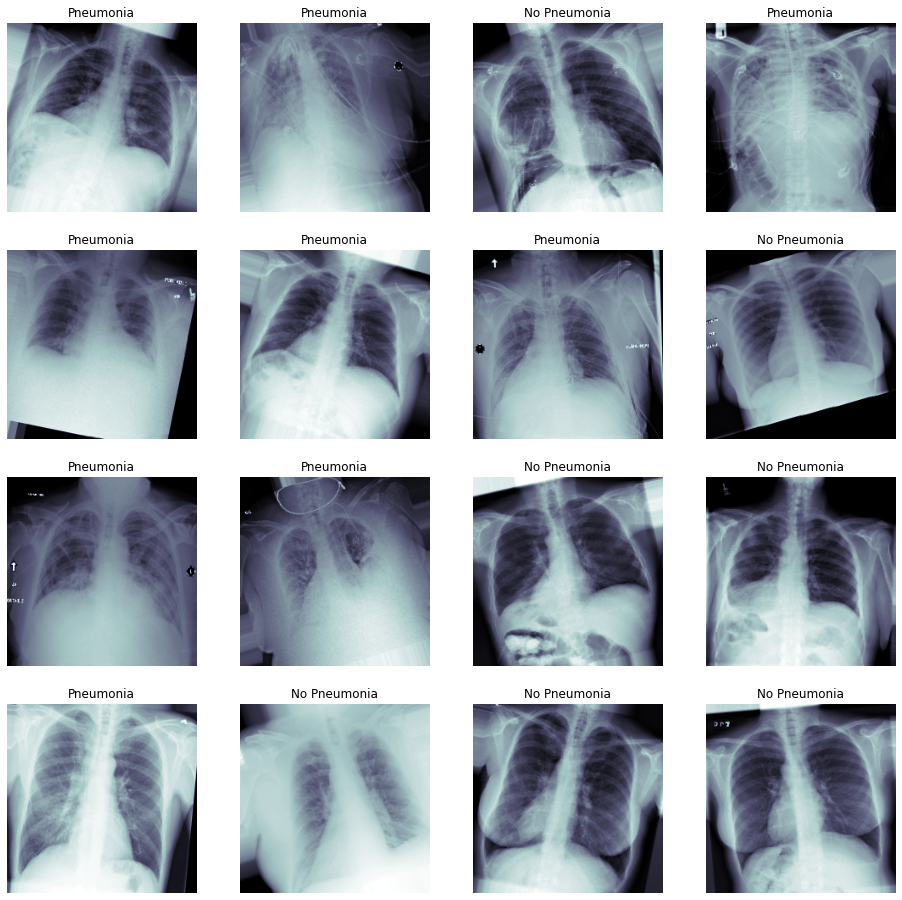

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
my_train_idg=my_image_augmentation("train")
train_gen=make_train_gen(my_train_idg,train,128,224)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model
vgg_model= load_pretrained_model()
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
weight_path="./xray_class_my_model.best.hdf5"
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= min, 
                             save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', 
                      mode= min, 
                      patience=5)
callbacks_list = [checkpoint, early]
def build_my_model(vgg_model):
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    new_model = Sequential()
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = keras.optimizers.Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model
model1=build_my_model(vgg_model)

model1.summary()



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [14]:
#training 
history=model1.fit_generator(train_gen, 
                                  validation_data = (valX, valY),
                                  callbacks=callbacks_list,
                                  epochs = 15)

Epoch 1/15
18/18 [==============================] - 80s 4s/step - loss: 0.7525 - binary_accuracy: 0.5074 - val_loss: 0.7625 - val_binary_accuracy: 0.4050

Epoch 00001: val_loss improved from inf to 0.76252, saving model to ./xray_class_my_model.best.hdf5
Epoch 2/15
18/18 [==============================] - 58s 3s/step - loss: 0.7081 - binary_accuracy: 0.5389 - val_loss: 0.6377 - val_binary_accuracy: 0.6550

Epoch 00002: val_loss improved from 0.76252 to 0.63767, saving model to ./xray_class_my_model.best.hdf5
Epoch 3/15
18/18 [==============================] - 62s 3s/step - loss: 0.6833 - binary_accuracy: 0.5672 - val_loss: 0.7373 - val_binary_accuracy: 0.4600

Epoch 00003: val_loss did not improve from 0.63767
Epoch 4/15
18/18 [==============================] - 62s 3s/step - loss: 0.6813 - binary_accuracy: 0.5830 - val_loss: 0.6694 - val_binary_accuracy: 0.6050

Epoch 00004: val_loss did not improve from 0.63767
Epoch 5/15
18/18 [==============================] - 66s 4s/step - loss: 0.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model1.load_weights(weight_path)
pred_Y = model1.predict(valX, batch_size = 32, verbose = True)

200/200 [==============================] - 6s 32ms/step


In [17]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr,tpr,_=metrics.roc_curve(t_y,p_y)
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    return
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)
## what other performance statistics do you want to include here besides AUC? 


def plot_confusion_matrix(t_y,p_y):
    sns.heatmap(metrics.confusion_matrix(t_y,p_y),annot=True)

def clinical_metrics(t_y,p_y,verbose=1):
    """ takes in true values and prediction and returns specificity and sensitivity"""
    tn, fp, fn, tp = perf_measure(t_y,p_y)
    try:
        specificity= tn/(tn+fp)
    except:
        print("Zero division")
        specificity=None
    try:
        sensitivity=tp/(tp+fn)
    except:
        print("Zero division")
        sensitivity=None
        
    precision=precision_score(t_y,p_y)
    f1=f1_score(t_y,p_y)
    accuracy=accuracy_score(t_y,p_y)
    if verbose==1:
        print(f" Model has a sensitivity AKA recall of {sensitivity:.2f} \n Model has specificity of {specificity:.2f} \n Model has precision of {precision:.2f}\n Model has f1_score of {f1:.2f}\n Model has accuracy of {accuracy:.2f}")
    return {"accuracy":accuracy,"precision":precision,"f1":f1,"recall":sensitivity}
   

    
#Also consider plotting the history of your model training:

plt.style.use('seaborn-deep')
def plot_history(history):
    histo=history.history
    fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(20,10))
    ax1.plot(histo["val_loss"],"r-")
    ax1.plot(histo["loss"][1:],"b-")
    ax1.legend(["val_loss","train_loss"])
    ax2.plot(histo["val_binary_accuracy"][1:],"r-")
    ax2.plot(histo["binary_accuracy"],"b-")
    ax2.legend(["val_accuracy","train_accuracy"])
    plt.suptitle("Performance Over Training Epochs",fontsize=20)

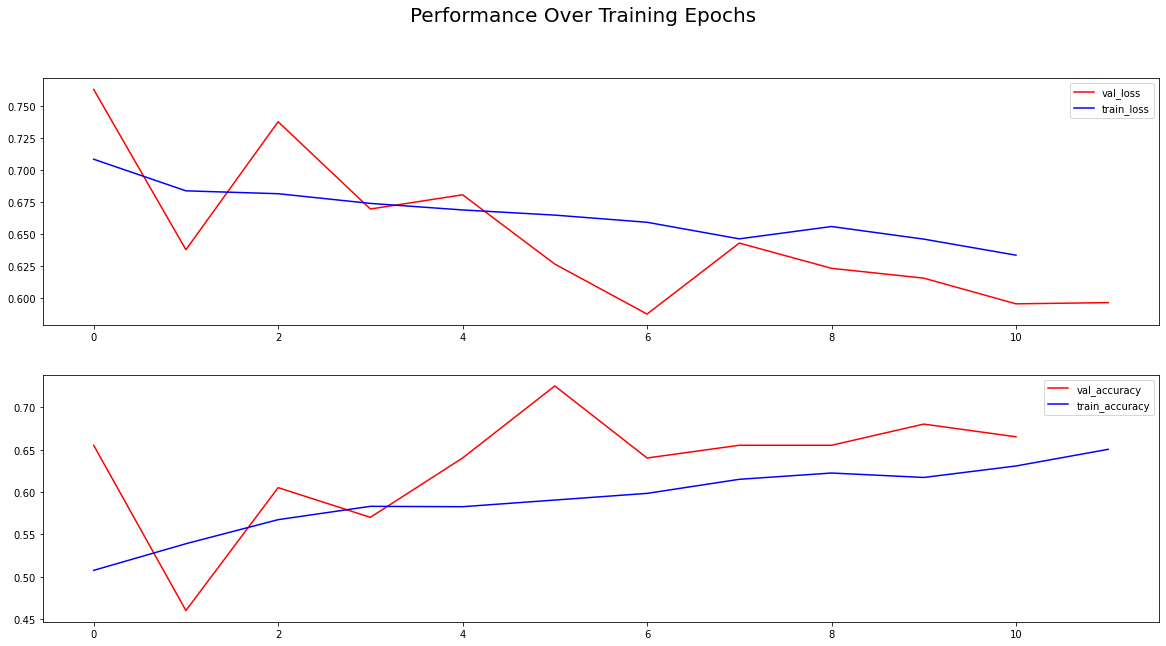

In [18]:
## plot figures
plot_history(history)

Note here I skipped the first epich as it was too large of a loss that it scaled up the graph to a smaller resolution making the later epochs seem like a straight line 

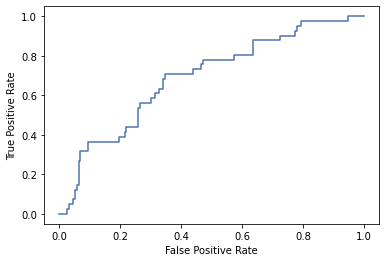

In [19]:
plot_auc(valY,pred_Y)


 Model has a sensitivity AKA recall of 0.17 
 Model has specificity of 0.34 
 Model has precision of 0.34
 Model has f1_score of 0.35
 Model has accuracy of 0.72


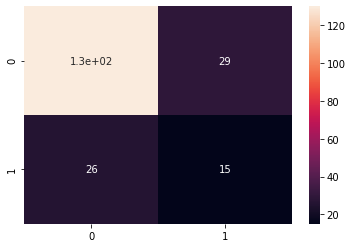

In [20]:
#assuming threshold is 0.5
pred=[1 if i>0.5 else 0 for i in pred_Y ]
clinical_metrics(valY,pred)
plot_confusion_matrix(valY,pred)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division
Zero division


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


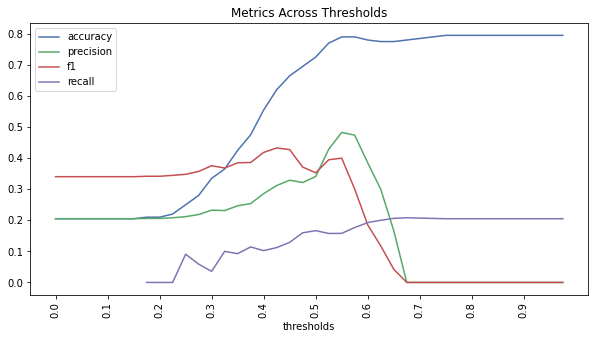

In [21]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
thresholds=np.arange(0,1,0.025)
from collections import defaultdict
scores_dict = defaultdict(list)
for th in thresholds:
    pred=[1 if i>th else 0 for i in pred_Y ]
    d=clinical_metrics(valY,pred,verbose=0)
    for key, date in d.items():
        scores_dict[key].append(date)
plt.figure(figsize=(10,5))
for k,v in scores_dict.items():
    plt.plot(thresholds,v,label=k)
plt.legend()
plt.title("Metrics Across Thresholds")
plt.xticks(np.arange(0,1,0.1),rotation=90)
plt.xlabel("thresholds")
plt.show()

I would say at about 0.56 seems decent however we would have alot of false negatives which is a problem , also recall does not change after 0.5 really so I think 0.56 is a good choice plus it will provide us with a good f1 score of 0.40( note i know that in real life this is not acceptable..but i just want to finish project haha)

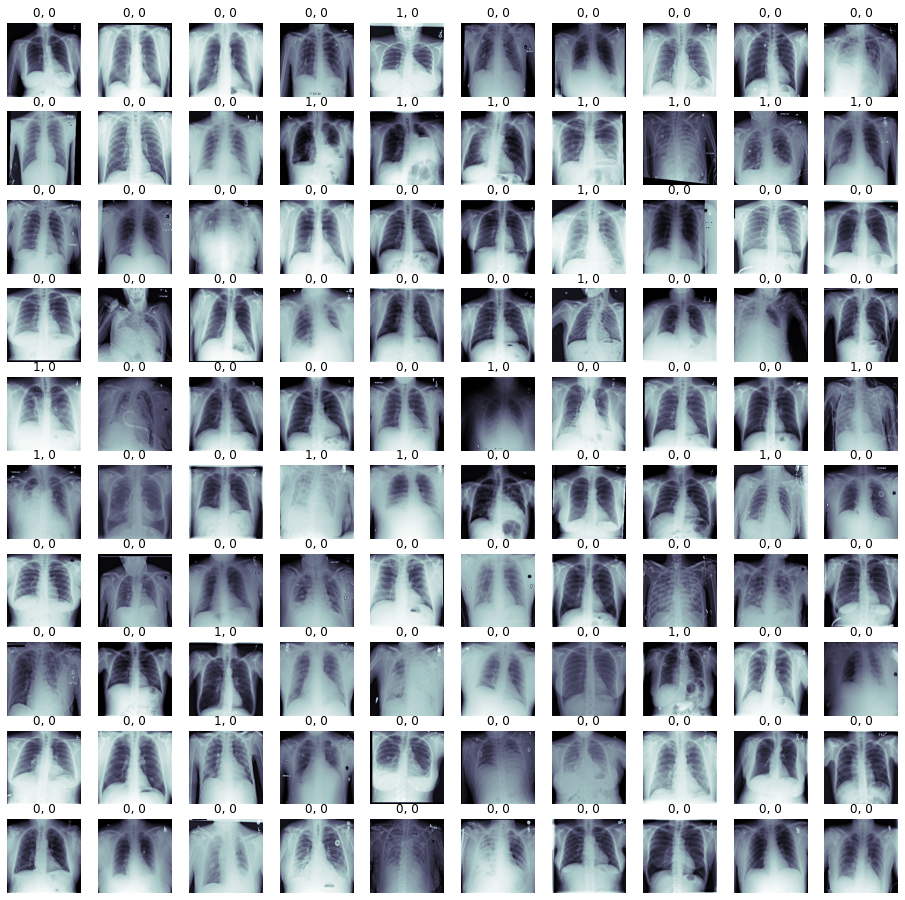

In [27]:
## Let's look at some examples of true vs. predicted with our best model: 



fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.77:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.77: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

 Model has a sensitivity AKA recall of 0.16 
 Model has specificity of 0.54 
 Model has precision of 0.54
 Model has f1_score of 0.40
 Model has accuracy of 0.81


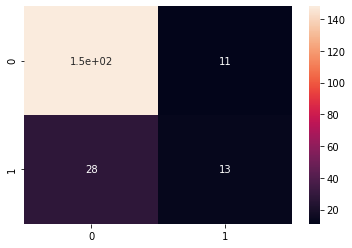

In [28]:
#assuming threshold is 0.78
pred=[1 if i>0.56 else 0 for i in pred_Y ]
clinical_metrics(valY,pred)
plot_confusion_matrix(valY,pred)

In [31]:
## Just save model architecture to a .json:

model_json = model1.to_json()
with open( "./my_model1.json", "w") as json_file:
    json_file.write(model_json)

In [32]:
## note the previous saving cell caused me alot of errors for some reason so I will bypass it by just using keras.save_model
model1.save("./my_model.json")